In [36]:
pip install kagglehub


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [37]:
import kagglehub
import shutil
import os

# Step 1: Download the dataset
path = kagglehub.dataset_download("ransakaravihara/aerial-imagery-semantic-segmentation-dataset")
print("Downloaded to temporary folder:", path)

# Step 2: Move it to your target raw folder
target_path = r"C:\Users\tsion\Downloads\SatelliteSegmentationProjectDL\data\raw"

# Make sure the destination exists
os.makedirs(target_path, exist_ok=True)

# Step 3: Move or copy files from temporary location
for root, dirs, files in os.walk(path):
    for file in files:
        source_file = os.path.join(root, file)
        rel_path = os.path.relpath(source_file, path)
        destination_file = os.path.join(target_path, rel_path)

        os.makedirs(os.path.dirname(destination_file), exist_ok=True)
        shutil.copy2(source_file, destination_file)

print("✅ Dataset moved to:", target_path)


Downloaded to temporary folder: C:\Users\tsion\.cache\kagglehub\datasets\ransakaravihara\aerial-imagery-semantic-segmentation-dataset\versions\1
✅ Dataset moved to: C:\Users\tsion\Downloads\SatelliteSegmentationProjectDL\data\raw


# Step 1: Setup and imports



In [39]:
import os
import shutil
import random
from glob import glob

# Set seed for reproducibility
random.seed(42)


# Step 2: Define source and target directories 

In [41]:
# Source paths in raw folder
RAW_IMAGES_DIR = 'data/raw/images'  # adjust if your folder names differ
RAW_MASKS_DIR = 'data/raw/masks'

# Target directories for splits
TRAIN_IMAGES_DIR = 'data/train/images'
TRAIN_MASKS_DIR = 'data/train/masks'

VAL_IMAGES_DIR = 'data/validation/images'
VAL_MASKS_DIR = 'data/validation/masks'

TEST_IMAGES_DIR = 'data/test/images'
TEST_MASKS_DIR = 'data/test/masks'

# Make sure target directories exist
for folder in [TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, VAL_IMAGES_DIR, VAL_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR]:
    os.makedirs(folder, exist_ok=True)


# Step 3: List image files and split

In [43]:
# List all image files in raw images directory
image_files = glob(os.path.join(RAW_IMAGES_DIR, '*.jpg'))  # or .jpg, adjust if needed

print(f"Total images found: {len(image_files)}")

# Shuffle
random.shuffle(image_files)

# Split ratios
total = len(image_files)
train_count = int(0.7 * total)
val_count = int(0.15 * total)
test_count = total - train_count - val_count

train_files = image_files[:train_count]
val_files = image_files[train_count:train_count+val_count]
test_files = image_files[train_count+val_count:]


Total images found: 1305


# Step 4: Copy files to respective folders

In [45]:
def copy_files(file_list, src_img_dir, src_mask_dir, tgt_img_dir, tgt_mask_dir):
    for img_path in file_list:
        # Extract filename only
        filename = os.path.basename(img_path)
        
        # Copy image
        shutil.copy(img_path, os.path.join(tgt_img_dir, filename))
        
        # Copy corresponding mask (assumes same filename in masks)
        mask_path = os.path.join(src_mask_dir, filename)
        if os.path.exists(mask_path):
            shutil.copy(mask_path, os.path.join(tgt_mask_dir, filename))
        else:
            print(f"⚠️ Mask not found for {filename}")

# Copy train
copy_files(train_files, RAW_IMAGES_DIR, RAW_MASKS_DIR, TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)
print(f"✅ Copied {len(train_files)} train images and masks")

# Copy validation
copy_files(val_files, RAW_IMAGES_DIR, RAW_MASKS_DIR, VAL_IMAGES_DIR, VAL_MASKS_DIR)
print(f"✅ Copied {len(val_files)} validation images and masks")

# Copy test
copy_files(test_files, RAW_IMAGES_DIR, RAW_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR)
print(f"✅ Copied {len(test_files)} test images and masks")


✅ Copied 913 train images and masks
✅ Copied 195 validation images and masks
✅ Copied 197 test images and masks


# 📌 Task 1: Visualize Random Image + Mask Pairs

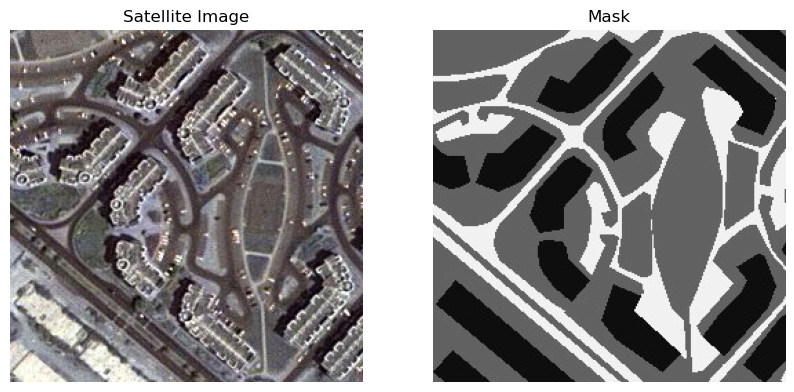

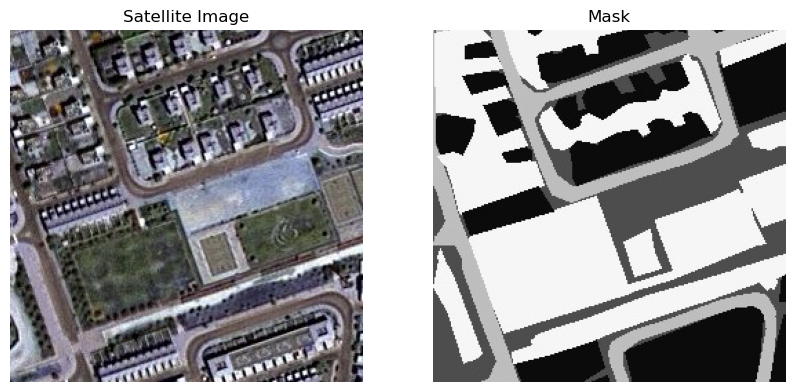

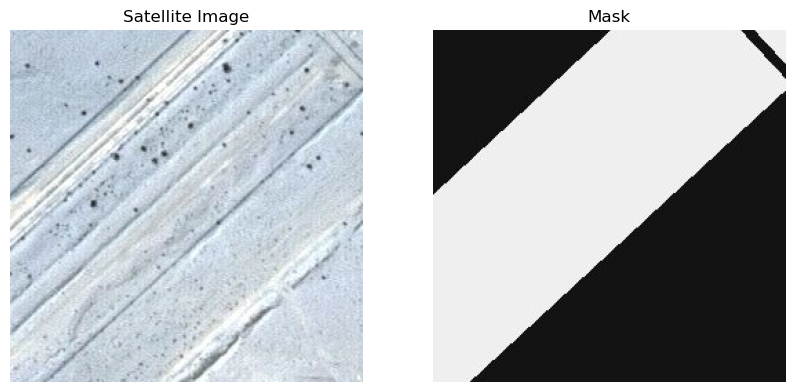

In [47]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import os

def visualize_samples(images_dir, masks_dir, n=3):
    files = os.listdir(images_dir)
    samples = random.sample(files, n)
    
    for file in samples:
        img_path = os.path.join(images_dir, file)
        mask_path = os.path.join(masks_dir, file)
        
        # Read image (convert BGR to RGB for display)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        # Read mask (assume single channel)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Plot side-by-side
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title('Satellite Image')
        plt.imshow(img)
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Visualize 3 random samples from training data
visualize_samples('data/train/images', 'data/train/masks', n=3)


# 📌 Task 2: Preprocessing Functions

In [49]:
def preprocess_image(img_path, target_size=(256,256)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # normalize
    return img.astype(np.float32)

def preprocess_mask(mask_path, target_size=(256,256)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Assume mask pixels are 0 or 255, convert to 0/1
    mask = (mask > 127).astype(np.float32)
    return mask[..., np.newaxis]  # add channel dim for model


# 📌 Task 3: Lightweight Dataset Loader

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

class SatelliteSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = os.listdir(images_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        
        img = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)
        
        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2,0,1)  # HWC to CHW
        mask = torch.from_numpy(mask).permute(2,0,1)  # add channel
        
        if self.transform:
            img, mask = self.transform(img, mask)
        
        return img, mask

# Example usage
train_dataset = SatelliteSegmentationDataset('data/train/images', 'data/train/masks')
# ✅ Define the validation dataset
validation_dataset = SatelliteSegmentationDataset('data/validation/images', 'data/validation/masks')

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
# ✅ Updated DataLoader setup for Windows & Jupyter stability
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")


Training samples: 913


# 📌 Task 4: Considerations for Deep Learning Tasks on Your PC

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.dconv_down1 = DoubleConv(n_channels, 32)
        self.dconv_down2 = DoubleConv(32, 64)
        self.dconv_down3 = DoubleConv(64, 128)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_up2 = DoubleConv(128 + 64, 64)
        self.dconv_up1 = DoubleConv(64 + 32, 32)
        
        self.conv_last = nn.Conv2d(32, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        x = self.dconv_down3(x)
        
        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return torch.sigmoid(out)

# Instantiate model
model = UNet(n_channels=3, n_classes=1)

print(model)


UNet(
  (dconv_down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 12

# 📌 Task 5: Define Loss, Metrics & Optimizer

In [58]:
# Dice coefficient for metric and loss
def dice_coeff(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred, target):
        return 1 - dice_coeff(pred, target)

# Combined loss
bce_loss = nn.BCELoss()
dice_loss = DiceLoss()

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# 📌 Task 6: Training Loop (Simplified)

In [61]:
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0
    
    for imgs, masks in tqdm(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    val_dice = 0
    
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            outputs = model(imgs)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()
            
            val_dice += dice_coeff(outputs, masks).item()
            
    return val_loss / len(dataloader), val_dice / len(dataloader)


# 📌 Task 7: Putting It All Together

In [64]:
# 📦 Early stopping utility
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [66]:
# 💾 Save and load checkpoints
def save_checkpoint(model, optimizer, epoch, path="models/latest_model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path="models/latest_model.pth"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'] + 1  # Resume from next epoch


In [68]:
# 🔁 Task 7: Training loop with Early Stopping and Checkpointing

# ✅ Make sure this line exists before this block
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

# Setup early stopping and resume from checkpoint if it exists
early_stopper = EarlyStopping(patience=3, min_delta=0.001)
start_epoch = 0

checkpoint_path = "models/latest_model.pth"
if os.path.exists(checkpoint_path):
    print("🔁 Resuming from last checkpoint...")
    start_epoch = load_checkpoint(model, optimizer, path=checkpoint_path)
else:
    print("🚀 Starting fresh training.")

# Training loop
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_dice = validate_epoch(model, validation_loader, device)

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Save checkpoint
    save_checkpoint(model, optimizer, epoch, path=checkpoint_path)

    # Check early stopping condition
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("🛑 Early stopping triggered — stopping training.")
        break


Using device: cpu
🚀 Starting fresh training.

Epoch [1/20]


100%|██████████| 229/229 [05:39<00:00,  1.48s/it]


📊 Train Loss: 0.7348 | Val Loss: 0.7794 | Val Dice: 0.5733

Epoch [2/20]


100%|██████████| 229/229 [06:13<00:00,  1.63s/it]


📊 Train Loss: 0.6546 | Val Loss: 0.7445 | Val Dice: 0.6109

Epoch [3/20]


100%|██████████| 229/229 [06:36<00:00,  1.73s/it]


📊 Train Loss: 0.6455 | Val Loss: 0.7359 | Val Dice: 0.6284

Epoch [4/20]


100%|██████████| 229/229 [07:23<00:00,  1.94s/it]


📊 Train Loss: 0.6312 | Val Loss: 0.7565 | Val Dice: 0.5880

Epoch [5/20]


100%|██████████| 229/229 [07:05<00:00,  1.86s/it]


📊 Train Loss: 0.6230 | Val Loss: 0.7289 | Val Dice: 0.6226

Epoch [6/20]


100%|██████████| 229/229 [06:51<00:00,  1.80s/it]


📊 Train Loss: 0.6150 | Val Loss: 0.6948 | Val Dice: 0.6520

Epoch [7/20]


100%|██████████| 229/229 [07:11<00:00,  1.88s/it]


📊 Train Loss: 0.6086 | Val Loss: 0.7406 | Val Dice: 0.5959

Epoch [8/20]


100%|██████████| 229/229 [06:49<00:00,  1.79s/it]


📊 Train Loss: 0.5928 | Val Loss: 0.7479 | Val Dice: 0.6176

Epoch [9/20]


100%|██████████| 229/229 [07:52<00:00,  2.06s/it]


📊 Train Loss: 0.5799 | Val Loss: 0.6844 | Val Dice: 0.6436

Epoch [10/20]


100%|██████████| 229/229 [06:37<00:00,  1.74s/it]


📊 Train Loss: 0.5800 | Val Loss: 0.6804 | Val Dice: 0.6580

Epoch [11/20]


100%|██████████| 229/229 [06:47<00:00,  1.78s/it]


📊 Train Loss: 0.5823 | Val Loss: 0.7451 | Val Dice: 0.6377

Epoch [12/20]


100%|██████████| 229/229 [07:10<00:00,  1.88s/it]


📊 Train Loss: 0.5769 | Val Loss: 0.9636 | Val Dice: 0.6364

Epoch [13/20]


100%|██████████| 229/229 [07:06<00:00,  1.86s/it]


📊 Train Loss: 0.5604 | Val Loss: 0.6892 | Val Dice: 0.6347
🛑 Early stopping triggered — stopping training.
